# Image processing

In [5]:
# imports
from ipywidgets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms
plt.rcParams['image.cmap'] = 'gray'
from PIL import Image
from pathlib import Path
import sys
import glob
import os
import shutil
import yaml

configpath = "configs/pipelin01config.yaml"
src_path = "src/2303_pez500/imgdat/"
dst_path = "dst/2303_pez500"

# useful functions
def get_imagepath(path):
    image_list = glob.glob(os.getcwd() + f"/{path}/*.png", recursive=True)
    if image_list == []:
            image_list = glob.glob(os.getcwd() + f"/{path}/*.csv", recursive=True)
    image_list.sort()
    return image_list

def save_params(section,vals2save):
    try:
        with open(configpath, 'r') as file:
            conf = yaml.safe_load(file)
        if conf == None:
            raise Exception("test")
    except: 
        conf = {
            "Paths": {
                "srcpath": "./src",
                "dstpath": "./dst"
            }
        }
    
    sectionnotexistflag = False
    try: sectionnotexistflag = section not in conf
    except: pass
    if sectionnotexistflag:
        conf[section] = {}
    for key, val in vals2save.items():
        conf[section].update({key:val})

    with open(configpath, 'w') as file:
        yaml.dump(conf, file)
        
def gen_filename(path2folder, filename):
        i = 0
        try:
            while os.path.exists(f"{path2folder}/{filename}{i}.png"):
                i += 1
        except: pass
        return f"{path2folder}/{filename}{i}.png"
    
def load_img(impath):
    """
    load_img 
    :param path: path to image
    :param :
    """
    try:
        im = Image.open(impath)
    except: 
        im = Image.fromarray(np.genfromtxt(impath, delimiter=","))
    finally: gray = im.convert('L')
    #width, heigth = im.size
    #im_array = np.array(gray.getdata()).reshape(heigth, width)
    #df_im = pd.DataFrame(im_array)
    return gray

In [6]:
# if opencv/cv2 is not installed uncomment next line
# pip install opencv-python

## Raw Images
The raw mages have been retrieved with a ultrasonix ultrasound machine using a prototyp of a poly-CMUT

In [7]:
# Loading of the input image
imlst = get_imagepath(src_path)
@interact(imagenr=(0,len(imlst)-1))
def show_img(imagenr=0):
    im = load_img(imlst[imagenr])
    _=plt.imshow(im)

interactive(children=(IntSlider(value=0, description='imagenr', max=509), Output()), _dom_classes=('widget-int…

## Cropping Image

In [8]:
def im2np(im):
    width, heigth = im.size
    im_array = np.array(im.getdata()).reshape(heigth, width)
    return im_array
def clean_dir(path):
    try: shutil.rmtree(path)
    except: pass
    os.makedirs(path)

In [9]:
import os
def im_crop(im: Image = None, crop_dat: tuple = (0,0,0,0), mode: int = 1, path: str = None):
    """
    im_crop can crop images using PIL.Image and can optionally save it to a path
    
    :param im: PIL:Image object that should be cropped
    :param crop_dat: Tuple containing how many pixels to crop (left, top, right, bottom)
    :param mode: Setting processing mode. 1 = returning PL.Image object; 2 = saving picture with same to path entered in path atribute
    :param path: Path to save picture to
    """
    left,top,right,bottom = crop_dat
    width, height = im.size
    im_crop = im.crop((left, top, width-right, height-bottom))
    if mode == 1:
        return im_crop
    if mode == 2:
        im_crop.save(gen_filename(path,"image"))

In [10]:
imglist = get_imagepath(src_path)
hight, width = np.array(load_img(imglist[1])).shape
left= IntSlider(min=0, max=width, step=1, value=0)
top= IntSlider(min=0, max=hight, step=1, value=0)
right= IntSlider(min=0, max=width, step=1, value=0)
bottom= IntSlider(min=0, max=hight, step=1, value=0)
pic= IntSlider(min=0, max=len(imglist)-1, step=1, value=0)


def im_crop_caller(left,right,top,bottom, pic):
    im = load_img(imglist[pic])
    _=plt.imshow(im_crop(im, (left,top,right,bottom),1))
    plt.axis('off')
_=interact(im_crop_caller,left=left,top=top,right=right,bottom=bottom, pic=pic)

interactive(children=(IntSlider(value=0, description='left', max=327), IntSlider(value=0, description='right',…

In [11]:
# save values to config.yaml
vals2save={
        "left": left.value,
        "top": top.value,
        "right": right.value,
        "bottom": bottom.value
    }
save_params("Cropping", vals2save)

In [12]:
# convert all pictures in imdata/raw
dir_cropped= os.path.join(dst_path,"cropped")
clean_dir(dir_cropped)
image_list = get_imagepath(src_path)
for pic in image_list:
    im_crop(load_img(pic), (left.value,top.value,right.value,bottom.value),2,dir_cropped)
src_path=dir_cropped

## OpenCV

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [14]:
image_list = get_imagepath(src_path)
image_list.sort()

@interact(x=(0, len(image_list)-1))
def sel_image(x):
    global img
    global img_gray
    global img_rgb
    img = cv2.imread(image_list[x])
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    _=plt.imshow(img)

interactive(children=(IntSlider(value=254, description='x', max=509), Output()), _dom_classes=('widget-interac…

## Thresholding
#### Manual thresholding

In [15]:
def trans_threshold(img_gray, thrval):
    _, threshold = cv2.threshold(img_gray, thrval, 255, cv2.THRESH_BINARY)
    return threshold

thrval= IntSlider(min=0, max=255, step=1, value=200)
def threshold(thrval):
    plt.imshow(trans_threshold(img_gray, thrval))
_=interact(threshold,thrval=thrval)

interactive(children=(IntSlider(value=200, description='thrval', max=255), Output()), _dom_classes=('widget-in…

img_thr = trans_threshold(img_gray, thrval.value)
_=plt.imshow(img_thr)

In [16]:
save_params("Thresholding",{"thrval": thrval.value})

In [18]:
#tranform all images
image_list = get_imagepath(src_path)
dir_thr = os.path.join(dst_path, "thresholded")
clean_dir(dir_thr)
for pic in image_list:
    im=cv2.imread(pic)
    im_thr = trans_threshold(im, thrval.value)
    plt.imsave(gen_filename(dir_thr,"image"), im_thr, format='png')

#### Otsu automatic thresholding

In [ ]:
img_otsu=img_gray.copy()

def otsu_tune():
    x=10 #doesn't seem to cahnge anything at all
    (T, im_otsu) = cv2.threshold(img_otsu, x, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    plt.imshow(im_otsu)
_=otsu_tune()

### Summary threshold
It seems like manual Thresholding is better


## Drawing Edges on src image

In [28]:
imglstcrp = get_imagepath(dir_cropped)
imglstthr = get_imagepath(dir_thr)
imglstcrp.sort()
imglstthr.sort()

In [20]:
def gen_contours(src=None,orig=None, nrconts=4):
    src_gray = src.copy()
    src_orig = orig.copy()
    contours, hierarchy = cv2.findContours(src_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(contours, key=cv2.contourArea)[0 if len(contours)<=nrconts else -nrconts-1:-1]
    final_image = cv2.drawContours(src_orig,cnt, -1, (0, 255, 0), 2)
    return final_image

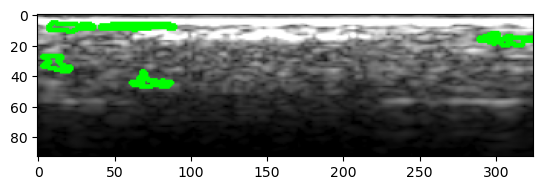

In [21]:
nrconts=5
imnr = 3
img = cv2.imread(imglstcrp[imnr])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_thr = cv2.imread(imglstthr[imnr])[:,:,2]
_=plt.imshow(gen_contours(img_thr,img_rgb,nrconts=nrconts))
save_params("Contour1", {"nrconts": nrconts})

In [22]:
# apply threshold on all images
dir_cont = os.path.join(dst_path,"contour")
clean_dir(dir_cont)
for picnr in range(len(imglstcrp)):
    img = cv2.imread(imglstcrp[picnr])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_thr = cv2.imread(imglstthr[picnr])[:,:,2]
    
    im_contour = gen_contours(img_thr,img_rgb,nrconts=nrconts)
    plt.imsave(gen_filename(dir_cont,"image"), im_contour, format='png')

### Erosion and Dilation
1. Eliminating smaller noise patches by shrinking all the areas, so that only the larger ones, which more likely represent an error, stay left
1. Evaluating several different kernels for dialating for best performance
    - it seems best to only shrink vertically, because all the wanted areas are very slim and vanish quickly when shrinkung vertically
    - Horisontal line kernel is beeing used for further processing

In [23]:
v_kernel = np.array(
[[0.,1.,0.],
 [0.,1.,0.],
 [0.,1.,0.]], np.uint8)
h_kernel = np.array(
    [[0.,0.,0.],
     [1.,1.,1.],
     [0.,0.,0.]],np.uint8)
cross_kernel = np.array(
    [[0.,1.,0.],
     [1.,1.,1.],
     [0.,1.,0.]],np.uint8)
ones_kernel = np.ones((3,3))

kernel = {"vertical":v_kernel, "horizontal": h_kernel, "cross": cross_kernel, "square":ones_kernel}

In [24]:
def ero_dil(kernelnr=1,ero_iterations=4, dil_iterations=0, img_thr=None, img_orig=None):
    global img_dilation
    #kernel = np.ones((kernel, kernel), np.uint8)
    kernel_name = list(kernel.keys())[kernelnr]
    img_erosion = cv2.erode(img_thr, kernel[kernel_name], iterations=ero_iterations)
    img_dilation = cv2.dilate(img_erosion, kernel[kernel_name], iterations=dil_iterations)
    
    fig, axs = plt.subplots(4)
    _=axs[0].imshow(img_thr)
    _=axs[0].set_title(f"Threshold using {kernel_name} filter")
    _=axs[1].imshow(img_erosion)
    _=axs[1].set_title(f"Erosion")
    _=axs[2].imshow(img_dilation)
    _=axs[2].set_title("Dilation")
    _=axs[3].imshow(gen_contours(img_dilation,img_orig))
    _=axs[3].set_title("Original Image with drawn contour")
    fig.subplots_adjust(hspace=0.5)
    for ax in axs:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [29]:
kernelnr = IntSlider(min=0, max=len(kernel)-1, step=1, value=1)
ero_iterations = IntSlider(min=0, max=20, step=1, value=4)
dil_iterations = IntSlider(min=0, max=20, step=1, value=4)
img_nr = IntSlider(min=0, max=len(imglstthr), step=1, value=4)

def ero_dil_caller(kernelnr=1,ero_iterations=4, dil_iterations=0, imgnr=3):
    img_erodil = cv2.imread(imglstthr[imgnr])[:,:,2]
    sel_image(imgnr)
    plt.close("all")
    ero_dil(kernelnr=kernelnr, ero_iterations=ero_iterations,dil_iterations=dil_iterations, img_orig=img_rgb, img_thr=img_erodil)
_=interact(ero_dil_caller,kernelnr=kernelnr, ero_iterations=ero_iterations,dil_iterations=dil_iterations, imgnr = img_nr)

interactive(children=(IntSlider(value=1, description='kernelnr', max=3), IntSlider(value=4, description='ero_i…

In [30]:
erodil_params = {
    "ero_iters": ero_iterations.value,
    "dil_iters": dil_iterations.value,
    "kernel": kernelnr.value
}
save_params("Erodil",erodil_params)

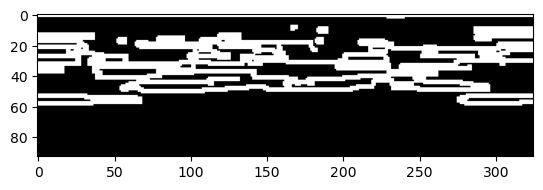

In [31]:
edges = cv2.dilate(cv2.Canny(img_dilation,0,255),None)

_=plt.imshow(edges)

In [32]:
conts=sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)

Shows one closed shape at a time:

In [33]:
@interact(x=(0, len(conts)-1))
def test(x):
    mask = np.zeros(img_thr.shape, np.uint8)
    masked = cv2.drawContours(mask,[conts[x]],-1,255,-1)
    _ = plt.imshow(masked)


interactive(children=(IntSlider(value=15, description='x', max=31), Output()), _dom_classes=('widget-interact'…

### Summary
- dilation connects backplate with defect when close to backplate
- erosion only on horizontal axis seems efficient
- the more erosion the more likely it is to miss smaller defects

# K-means

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2

In [ ]:
sample_image = img
img = cv2.cvtColor(sample_image,cv2.COLOR_BGR2RGB)
_=plt.imshow(sample_image)

In [ ]:
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

In [ ]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10

In [ ]:
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

_=plt.imshow(result_image)

### Adding up pixel values for each row

In [34]:
img = cv2.imread("dst/2303_pez500/thresholded/")
_ = plt.imshow(img)



In [35]:
df = pd.DataFrame(img[:,:,1])
df.sum(axis=1).plot()

### Siglan Processing (enhancement)
#### Goal: Filter out noise to only have Front/Back plate and the Defect

In [36]:
def filterplate(signal):
    """
    filterplate expects as input a 1d array of the sign of the first deviation,
    of the accumulated rows vector and removes the first bump of the signal, which is assumed to be the front plate
    """
    wobackfront = []
    peakcnt = 0
    flag = 0
    for val in signal:
        if peakcnt >= 1:
            wobackfront.append(val)
        else:
            if val == -1:
                flag = 1
            if val in [0,1] and flag == 1:
                peakcnt = 1
                wobackfront.append(val)
            else:
                wobackfront.append(0)
    return np.array(wobackfront)

In [45]:
def imgProcess1(path_orig, path_thr, highttrash_perc=10, moving_average=10, savefig = False, filter_plate=True, outputpath = None):
    
    # loading binary and thresholded image as pandas dataframe
    img = cv2.imread(path_thr)
    img_orig=cv2.imread(path_orig)
    df = pd.DataFrame(img[:,:,1])
    
    # Accumulating all Pixel values from image per row 
    plotdat=df.sum(axis=1)
    
    # reversing pandas series for better visualisation in plot down below
    plotdatindex=plotdat.index
    plotdat = plotdat.iloc[::-1]
    plotdat.index = plotdatindex
    
    # calculating moving average to smoothen out curve
    processed_dat=pd.Series(plotdat.rolling(moving_average).mean())

    if True:
        # threshold to filter out small peaks caused by noise
        new_processed_dat = []
        for val in processed_dat:
            if val <= processed_dat.max()/100*highttrash_perc or np.isnan(val):
                new_processed_dat.append(0)
            else: new_processed_dat.append(val)
        processed_dat = pd.Series(new_processed_dat)
        
    
    
    derivbool = False # toggels if vector should be analysed by doing derivation.
    if derivbool:
        deriv_dat=np.sign(pd.Series(processed_dat).diff())

        if filter_plate:
            # only usefull when back and frontplate are part of picture
            #removing front and back plate signal
            iter1=filterplate(deriv_dat)
            iter2 = filterplate(np.array(iter1[::-1]*-1))[::-1]*-1
            deriv_dat = iter2
            
    else:
        peaks, _ = scipy.signal.find_peaks(processed_dat, height=0)
        
    #plotting images
    fig, axs = plt.subplots(1,4,figsize=(10,5))
    bases=[]
    for i in range(len (axs)):
        bases.append(axs[i].transData)
    rot = transforms.Affine2D().rotate_deg(90)
    axs[0].imshow(img_orig, aspect = 18)
    axs[0].title.set_text(f"Original Image")
    axs[1].imshow(img, aspect = 18)
    axs[1].title.set_text(f"B/W Image")
    
    axs[2].plot(plotdat,transform= rot + bases[2])
    axs[2].title.set_text(f"Accum Pixel Val\nHightThrPerc={highttrash_perc}%")
    #axs[2].plot(processed_dat, transform= rot + bases[2])
    #axs[2].title.set_text(f"Processed with ma={moving_average}")
    
    if derivbool:
        axs[3].plot(deriv_dat, transform= rot + bases[3])
        axs[3].title.set_text("Filtered Sign change \nof 1st Deriv")
    else: 
        axs[3].plot(processed_dat, transform= rot + bases[3])
        axs[3].plot(peaks, processed_dat[peaks], "x", transform= rot + bases[3])
        axs[3].title.set_text(f"Local Maxima = {len(peaks)}")
    
    if savefig:
        fig.savefig(gen_filename(outputpath, "imageProcessed"))


In [42]:
#### imglstthr=get_imagepath("imdata/thresholded/")
imglstthr.sort()
imglstorig=get_imagepath(dir_cropped)
imglstorig.sort()
picturenr = IntSlider(min=0, max=len(imglstthr)-1, step=1, value=4)
highttrash_perc = IntSlider(min = 1, max=100, step=1, value=10)
masld = IntSlider(min = 1, max=30, step=1, value=10)

def img_process1_caller(imagenr=0, highttrash_perc=10, moving_average=10, filter_plate=False):
    imgProcess1(imglstorig[imagenr], imglstthr[imagenr], highttrash_perc=highttrash_perc, moving_average=moving_average, filter_plate=filter_plate)
_=interact(img_process1_caller,imagenr=picturenr, highttrash_perc=highttrash_perc, moving_average = masld)

interactive(children=(IntSlider(value=4, description='imagenr', max=509), IntSlider(value=10, description='hig…

In the graphic the stages of the processing can be seen.
1. Accumulation of all pixel values per row
1. Smoothening with Moving Average and applying a threshold value to filter out noise
1. Analysing the sign changes of the 1st deviation and cutting out the first and last -1 to 1 sequence
--> As a result with the right parameters 3

In [43]:
vals2save={
        "threshold": highttrash_perc.value,
        "movingaverage": masld.value
        }
save_params("Processing1", vals2save)

In [44]:
dir_processed = os.path.join(dst_path, "processed")
clean_dir(dir_processed)

In [46]:
# convertig all pictures
for cnt, imgpath in enumerate(imglstthr):
    imgProcess1(imglstorig[cnt], imgpath, highttrash_perc=7, moving_average=4, savefig = True, outputpath=dir_processed)
    plt.close("all") # supress displaying of plots

- The higher the threshold the higher the likelyhood of not detecting a defect
- 

#### Moving Average

In [ ]:
img = cv2.imread(imglstthr[2])
img_orig=cv2.imread(imglstorig[2])
df = pd.DataFrame(img[:,:,1])
# Accumulating all Pixel values from image horozontally 
plotdat=df.sum(axis=1)

maval = IntSlider(min=1, max=20, value=3)
f=lambda x: plt.plot(plotdat.rolling(x).mean())
interact(f, x=maval)

#### Savgol_Filter

In [ ]:
window= IntSlider(min=0, max=20, step=1, value=4)
poly = IntSlider(min=0, max=20, step=1, value=3)
def savgol_filetertest(windowsz, polynom):
    plotdat2=scipy.signal.savgol_filter(plotdat, windowsz,polynom)

    _=plt.plot(plotdat2)

_=interact(savgol_filetertest,windowsz=window, polynom = poly)